# Homework 4
<strong>Author:</strong> Morgan Byers <br/>
<strong>Date:</strong> April 26, 2024

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Question 1

In [2]:
#import all weeks csv
all_weeks = np.loadtxt('all_weeks.csv', skiprows=1, delimiter=',')
print(all_weeks.shape)

(501, 2)


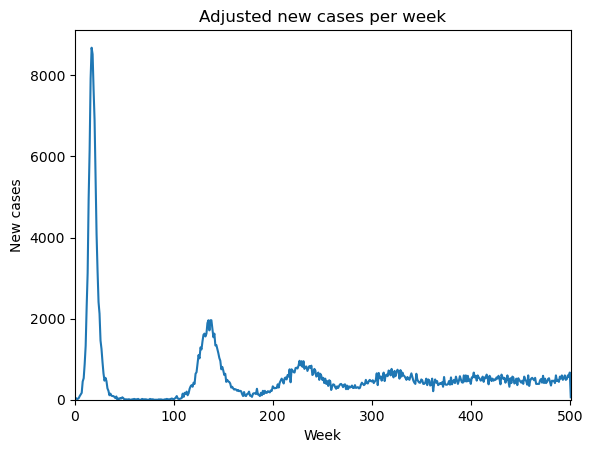

In [3]:
#researchers think they're only capturing 10 percent of cases, so adjust prevalence
adjusted_prevalence = all_weeks[:, 1] / 0.1
#plot weekly new cases as a sanity check
week_nums = all_weeks[:,0]
plt.plot(week_nums, adjusted_prevalence)
plt.ylim([0, np.max(adjusted_prevalence) + 0.05 * np.max(adjusted_prevalence)])
plt.xlim([0, len(week_nums)])

plt.xlabel('Week')
plt.ylabel('New cases')
plt.title('Adjusted new cases per week')
plt.show()

### Part a

In [4]:
from scipy.stats import expon

In [5]:
#I need to compute infections over time rather than just new infections
i = np.zeros(len(adjusted_prevalence))
#infection duration is exponentially distributed with 2 week avg
avg_duration = 2
for week_num, new_infections in enumerate(adjusted_prevalence):
    durations = expon.rvs(loc=avg_duration, size=int(new_infections))
    for duration in durations:
        i[week_num: week_num + int(duration)] += 1

/var/folders/lj/1yjg4cns3gnft8z3t9dnct5m0000gp/T/ipykernel_89958/3375419104.py:1: RuntimeWarning: divide by zero encountered in log
  plt.plot(week_nums, np.log(i))


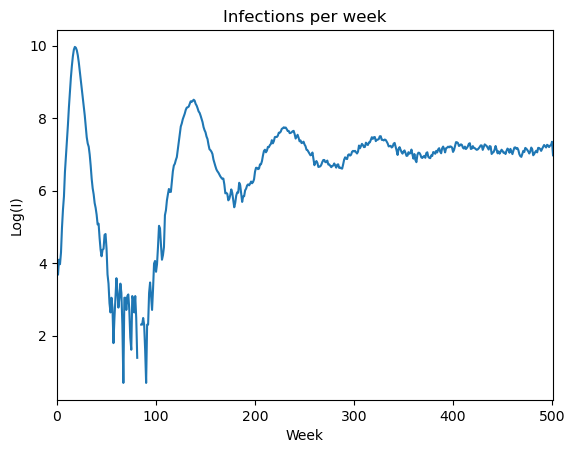

In [6]:
plt.plot(week_nums, np.log(i))
plt.xlim([0, all_weeks.shape[0]])

plt.xlabel('Week')
plt.ylabel('Log(I)')
plt.title('Infections per week')
plt.show()

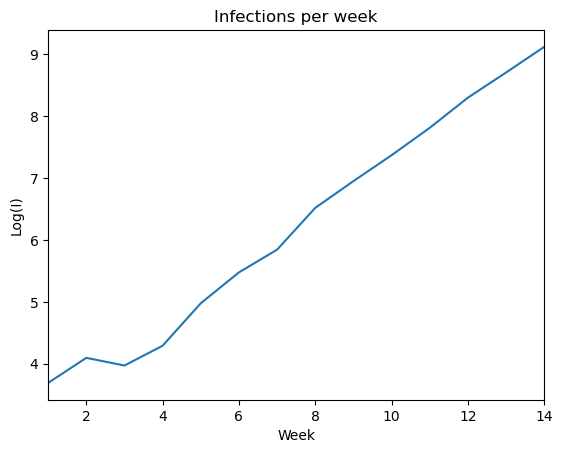

In [21]:
#show initial period of exponential growth
num_weeks = 14
plt.plot(week_nums[:num_weeks], np.log(i[:num_weeks]))
plt.xlim([1, week_nums[:num_weeks].shape[0]])

plt.xlabel('Week')
plt.ylabel('Log(I)')
plt.title('Infections per week')
plt.savefig('hw4_q1_a.png', dpi=200, bbox_inches='tight')
plt.show()

In [27]:
#use linear regression to estimate the slope
from scipy.stats import linregress

lr = linregress(week_nums[:num_weeks], np.log(i[:num_weeks]))
print(f'm_hat: {lr.slope}')
print(f'intercept: {lr.intercept}')
print(f'standard error: {lr.stderr}')

m_hat: 0.44416349859179827
intercept: 2.8921530571564293
standard error: 0.013541938031231996


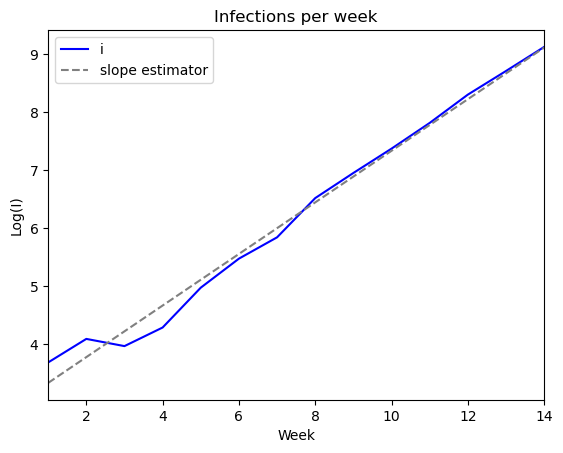

In [28]:
#plot line of best fit with data for sanity check
intercept = lr.intercept
m_hat = lr.slope
plt.plot(week_nums[:num_weeks], np.log(i[:num_weeks]), color='blue', label='i')

best_fit = [m_hat * x + intercept for x in week_nums[:num_weeks]]
plt.plot(week_nums[:num_weeks], best_fit, color='gray', linestyle='dashed', label='slope estimator')

plt.xlim([1, week_nums[:num_weeks].shape[0]])

plt.xlabel('Week')
plt.ylabel('Log(I)')
plt.legend(loc='best')
plt.title('Infections per week')
plt.savefig('hw4_q1_best_fit.png', dpi=200, bbox_inches='tight')
plt.show()

In [31]:
#compute r_0
gamma = 1/2
mu = 1/100
r_0 = 1 + (m_hat / (gamma + mu))
print(f'R_0 = {r_0:.4f}')

#find the 95% confidence interval around the slope
tails = 1.96 * lr.stderr
print(f'95% CI about m_hat: [{m_hat - tails:.4f}, {m_hat + tails:.4f}]')
#find the 95% CI around R0
r0_lower = 1 + ((m_hat - tails) / (gamma + mu))
r0_upper = 1 + ((m_hat + tails) / (gamma + mu))
print(f'95% CI about R_0: [{r0_lower:.4f}, {r0_upper:.4f}]')

R_0 = 1.8709
95% CI about m_hat: [0.4176, 0.4707]
95% CI about R_0: [1.8189, 1.9230]


## Question 3

In [2]:
#read data
base = 'HW4_Q3'
pos_data = np.loadtxt(base + '_pos.csv', delimiter = ',')
neg_data = np.loadtxt(base + '_neg.csv', delimiter = ',')
field_data = np.loadtxt(base + '_data.csv', delimiter = ',')
print(pos_data.shape, neg_data.shape, field_data.shape)

(300,) (200,) (300,)


### Part a

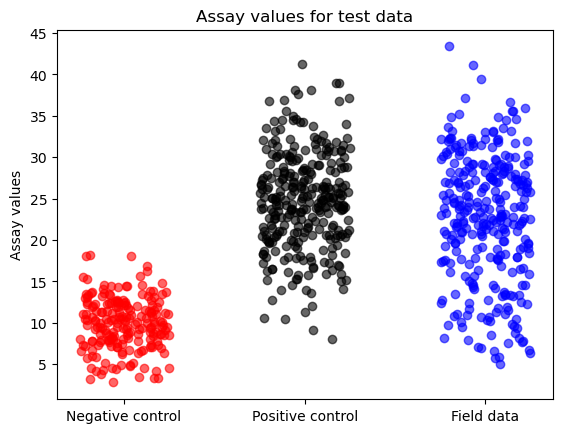

In [33]:
def jitter(x, data_len):
    offset = np.random.rand(data_len) 
    x_vals = np.where(offset > 0.5, x - (1 - offset), x + offset)
    return x_vals

plt.scatter(jitter(1, neg_data.shape[0]), neg_data, alpha = 0.6, color='red')
plt.scatter(jitter(3, pos_data.shape[0]), pos_data, alpha = 0.6, color='k')
plt.scatter(jitter(5, field_data.shape[0]), field_data, alpha = 0.6, color='blue')

plt.xticks([1, 3, 5], labels=['Negative control', 'Positive control', 'Field data'])
plt.ylabel('Assay values')
plt.title('Assay values for test data')

plt.savefig('hw4_q3a.png', dpi=200, bbox_inches='tight')
plt.show()

### Part b

In [3]:
def sensitivity(true_pos, false_neg):
    return true_pos / (true_pos + false_neg)

def specificity(true_neg, false_pos):
    return true_neg / (true_neg + false_pos)

def theta_hat(n_pos, n, se, sp):
    return ((n_pos / n) - (1 - sp)) / (se + sp - 1)

def phi_hat(n_pos, n):
    return n_pos / n

def J(se, sp):
    return se + sp - 1

In [4]:
#loop over all possible c values
c_min = np.min(pos_data)
c_max = np.max(neg_data)
c_vals = np.linspace(c_min, c_max, num=1000)
print(c_min, c_max)

#data collection
se = []
sp = []
theta = []
phi = []
J_c = []
true_pos_list = []
false_pos_list = []

#precompute n
n = pos_data.shape[0] + neg_data.shape[0]

for c in c_vals:
    true_pos = np.count_nonzero(pos_data[pos_data > c]) 
    false_pos = np.count_nonzero(neg_data[neg_data > c])
    true_pos_list.append(true_pos)
    false_pos_list.append(false_pos)

    #everything that wasn't classified as a positive is a negative
    true_neg = neg_data.shape[0] - false_pos
    false_neg = pos_data.shape[0] - true_pos

    #track results
    se.append(sensitivity(true_pos, false_neg))
    sp.append(specificity(true_neg, false_pos))
    theta.append(theta_hat(true_pos + false_pos, n, se[-1], sp[-1]))
    phi.append(phi_hat(true_pos + false_pos, n))
    J_c.append(J(se[-1], sp[-1]))

8.004882575342748 18.192601699670703


In [13]:
#find youden index
youden_idx = np.argmax(J_c)
print(f'Best cutoff at c = {c_vals[youden_idx]}')
print(f'Se = {se[youden_idx]}, Sp = {sp[youden_idx]}')
print(f'theta = {theta[youden_idx]}, phi = {phi[youden_idx]}')
print(f'J(c) = {J_c[youden_idx]}')

Best cutoff at c = 14.76610157377061
Se = 0.96, Sp = 0.96
theta = 0.6, phi = 0.592
J(c) = 0.9199999999999999


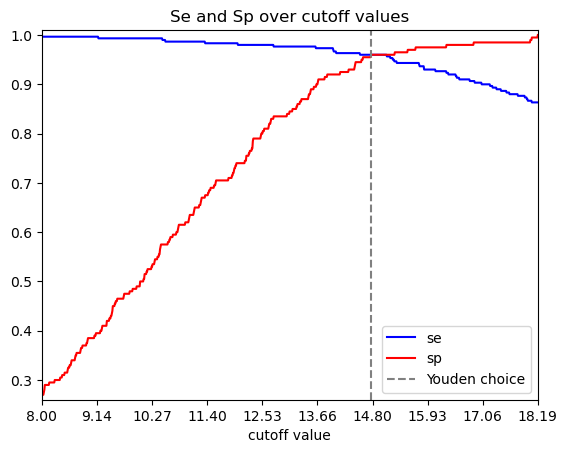

In [16]:
#plot sensitivity and specificity with Youden index
plt.plot(c_vals, se, color='blue', label='se')
plt.plot(c_vals, sp, color='red', label = 'sp')
plt.axvline(c_vals[youden_idx], linestyle='dashed', color='gray', label='Youden choice')

plt.ylim([np.min(sp) - 0.01, 1.01])
plt.xlim([c_vals[0], c_vals[-1]])
plt.xticks(np.linspace(c_min, c_max, num=10))

plt.legend(loc='best')
plt.xlabel('cutoff value')
plt.title('Se and Sp over cutoff values')

plt.savefig('hw4_q3b_se_sp.png', dpi=200, bbox_inches='tight')
plt.show()

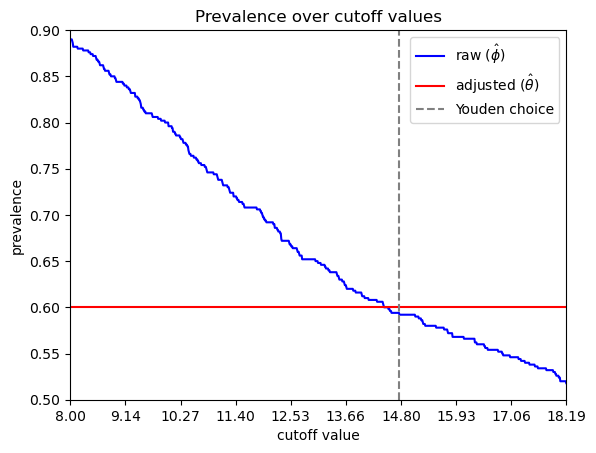

In [55]:
#plot theta and phi with Youden index
plt.plot(c_vals, phi, color='blue', label=r'raw ($\hat{\phi}$)')
plt.plot(c_vals, theta, color='red', label = r'adjusted ($\hat{\theta}$)')
plt.axvline(c_vals[youden_idx], linestyle='dashed', color='gray', label='Youden choice')

plt.ylim([0.5, 0.9])
plt.xlim([c_vals[0], c_vals[-1]])
plt.xticks(np.linspace(c_min, c_max, num=10))

plt.legend(loc='best')
plt.xlabel('cutoff value')
plt.ylabel('prevalence')
plt.title('Prevalence over cutoff values')

plt.savefig('hw4_q3b_theta_phi.png', dpi=200, bbox_inches='tight')
plt.show()

### Part c

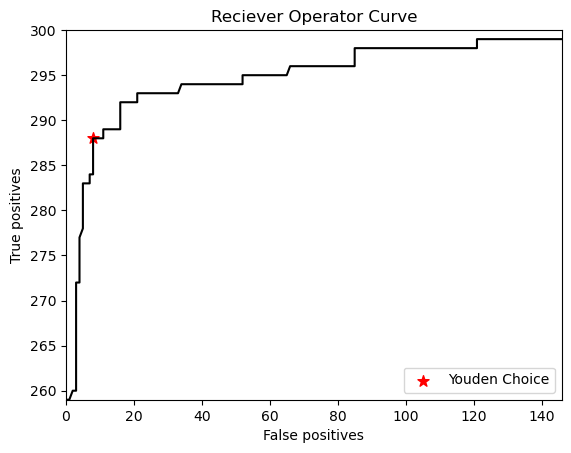

In [43]:
plt.plot(false_pos_list, true_pos_list, color='black')
plt.scatter(false_pos_list[youden_idx], true_pos_list[youden_idx], 
            color='red', marker='*', s=70, label='Youden Choice')

plt.xlim([false_pos_list[-1], false_pos_list[0]])
plt.ylim([true_pos_list[-1], true_pos_list[0] + 1])

plt.legend(loc='lower right')
plt.xlabel('False positives')
plt.ylabel('True positives')
plt.title('Reciever Operator Curve')

plt.savefig('hw4_q3c_roc.png', dpi=200, bbox_inches='tight')
plt.show()

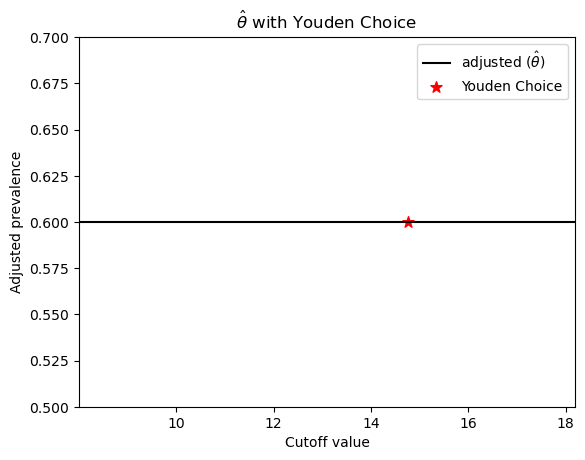

In [57]:
#plot theta with Youden choice
plt.plot(c_vals, theta, color='black', label = r'adjusted ($\hat{\theta}$)')
plt.scatter(c_vals[youden_idx], theta[youden_idx], 
            color='red', marker='*', s=70, label='Youden Choice')

plt.ylim([0.5, 0.7])
plt.xlim([c_vals[0], c_vals[-1]])
'''

plt.xticks(np.linspace(c_min, c_max, num=10))
'''
plt.legend(loc='best')
plt.xlabel('Cutoff value')
plt.ylabel('Adjusted prevalence')
plt.title(r'$\hat{\theta}$ with Youden Choice')

plt.savefig('hw4_q3c_theta.png', dpi=200, bbox_inches='tight')
plt.show()